In [2]:
import pandas as pd 
import shap
import catboost
import matplotlib.pyplot as plt 
from datetime import date

In [3]:
category = 'Candy & Chocolate' # get category 

# load best model
today = date.today()
#model = pd.read_pickle('models/'+category+'/best_performing_model_'+str(today)+'.sav') # catboost-regressor
model = pd.read_pickle('models/'+category+'/best_performing_model_2022-04-30.sav') # catboost-regressor

# load data 
df_train = pd.read_csv('data/' + category + '/df_train_lda.csv')
df_test = pd.read_csv('data/' + category + '/df_test_lda.csv')
df_train = df_train.drop(columns=['description','std_rating'])
df_test = df_test.drop(columns=['description','std_rating'])
df_train = df_train.dropna()
df_test = df_test.dropna()
X_train = df_train.drop(columns='avg_rating')
y_train = df_train['avg_rating']
X_test = df_test.drop(columns='avg_rating')
y_test = df_test['avg_rating']

In [4]:
# Get shap values 
explainer = shap.TreeExplainer(model) 
shap_values = explainer.shap_values(X_test)
shap_values_pandas = pd.DataFrame(shap_values)
shap_values_pandas.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-0.012967,-0.010631,0.006382,-0.011840,0.012675,-0.001035,-0.000373,-0.010015,0.003301,-0.007062,-0.000028,-0.000008,0.006506,0.035178,0.054635,0.019225,-0.054486,0.048254
1,-0.017430,-0.010887,0.060916,0.059465,-0.003532,-0.002491,-0.000234,0.007026,0.001717,-0.010735,-0.000023,-0.000202,-0.000143,0.033347,0.025104,-0.030430,0.020332,-0.120481
2,-0.020339,0.033932,0.126104,-0.014870,0.021468,0.001181,-0.000315,-0.000534,-0.016781,-0.003571,0.000036,-0.000284,0.001749,-0.022919,-0.027337,0.011854,0.009545,-0.004582
3,0.078345,0.045911,0.008595,-0.004883,0.049018,-0.004631,-0.000360,0.006459,-0.021145,-0.001392,-0.000022,-0.000010,-0.000752,0.128424,0.088907,0.022949,-0.034086,0.041338
4,0.104994,0.013885,0.024196,0.065136,-0.001503,-0.011750,-0.000388,-0.001059,0.005698,-0.002780,0.000033,-0.000386,-0.028221,-0.017911,-0.010632,0.045505,0.037164,-0.014043


In [5]:
shap_values_pandas.sum(axis=1)
print(explainer.expected_value)

4.090412617880721


The above matrix of dimension samples x number of features shows the shap values. The sum of each row gives the difference from the overall mean (the expected value). 

In [8]:
# shap force plot
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:200,:], X_test.iloc[:200,:])

The above figure shows how the features impact the prediction on the first 200 samples in the test data. Blue feature values are lowering the prediction and red feature values are increasing the prediction value. 


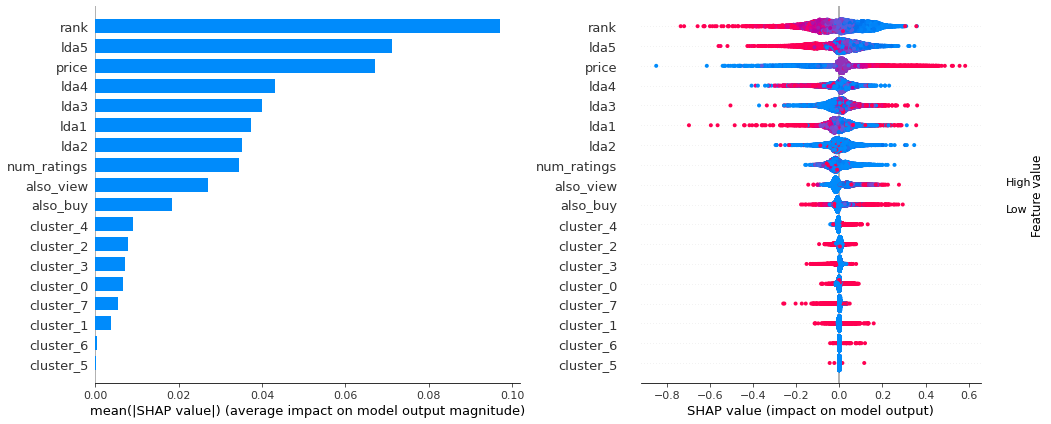

In [8]:
# shap summary plots
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
shap.summary_plot(shap_values, X_test, plot_type='bar', show=False, plot_size=None)
plt.subplot(1,2,2)
shap.summary_plot(shap_values, X_test, show=False, plot_size=None)
plt.tight_layout()
plt.show()

The above figures shows a summary of how the features impact the predictions. The right summary plot shows how the features impact the predictions and the left plot shows how the features impact the predictions in magnitude. 

From both plots, it is seen that the features with the highest impact on the predictions (average sales rating) are sales rank, the lda topics 1-5 and price. The clusers do not seem to have much impact on average rating and thus we could consider removing the clusters from the model. 

Looking at the sales rank at the right summary plot, it is seen that products with low sales rank (probably meaning that they sell a lot) tend to increase the prediction of average rating. Also it is seen that higher product prices often increases the prediction of average rating. 
KOMMENTER PÅ LDA TOPICS. 

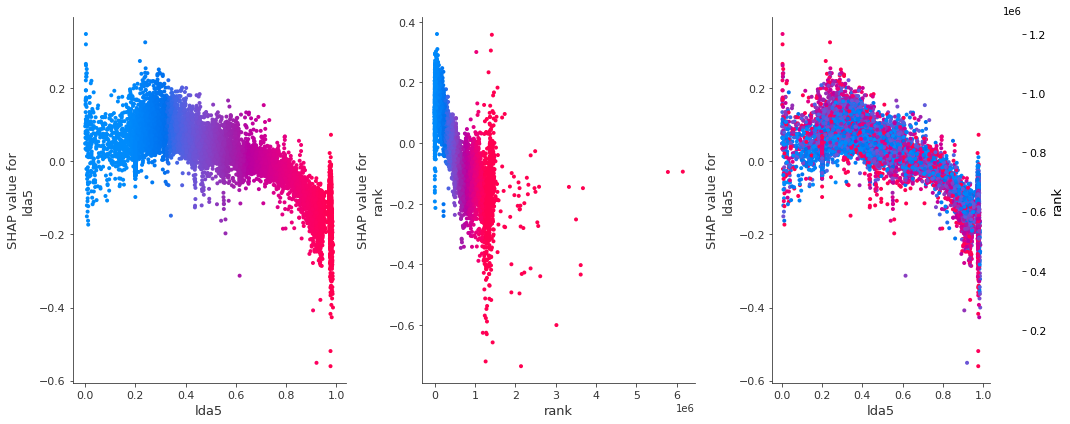

In [33]:
# shap summary plots
fig, axes = plt.subplots(1,3,figsize=(15,6))
shap.dependence_plot(ind='lda5', interaction_index='lda5',shap_values=shap_values, features=X_test, show=False, ax = axes[0])
shap.dependence_plot(ind='rank', interaction_index='rank',shap_values=shap_values, features=X_test, show=False, ax = axes[1])
shap.dependence_plot(ind='lda5', interaction_index='rank',shap_values=shap_values, features=X_test, show=False, ax = axes[2])
plt.tight_layout()
plt.show()

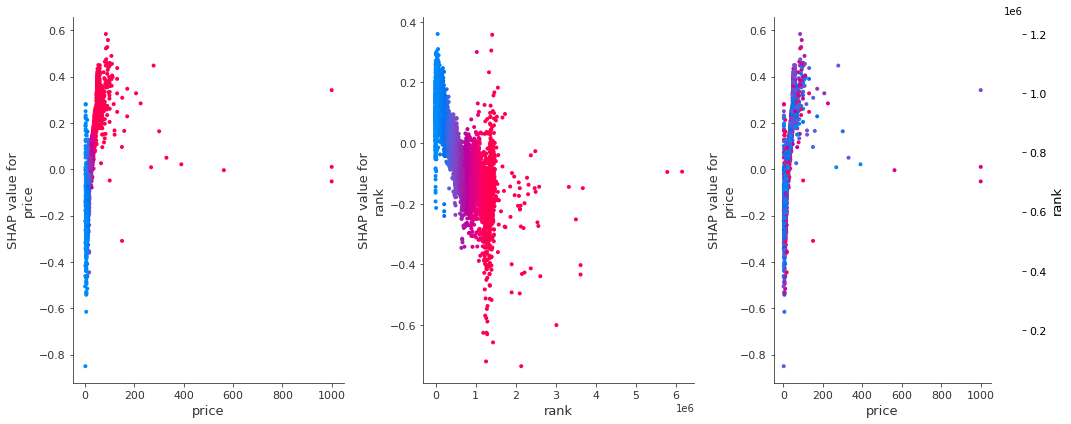

In [31]:
# shap summary plots
fig, axes = plt.subplots(1,3,figsize=(15,6))
shap.dependence_plot(ind='price', interaction_index='price',shap_values=shap_values, features=X_test, show=False, ax = axes[0])
shap.dependence_plot(ind='rank', interaction_index='rank',shap_values=shap_values, features=X_test, show=False, ax = axes[1])
shap.dependence_plot(ind='price', interaction_index='rank',shap_values=shap_values, features=X_test, show=False, ax = axes[2])
plt.tight_layout()
plt.show()

Partial dependence plots. Shows shap values against feature. Also possible to look at two-ways interactions. 

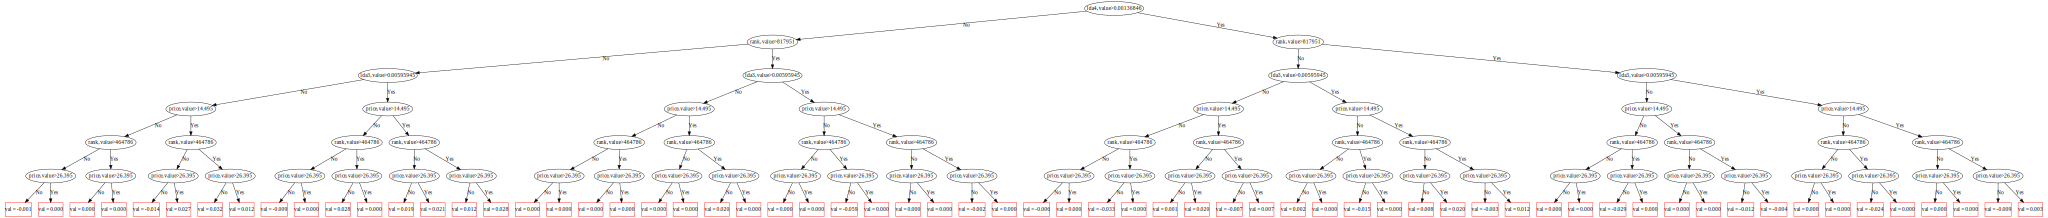

In [35]:
# plot of catboost tree  
pool = catboost.Pool(X_test, y_test, cat_features=[], feature_names=list(X_test.columns))
model.plot_tree(tree_idx=0,pool=pool)